In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import RcParams
import seaborn as sns
import mpl_finance as finance

# Workflow

* Exploratory data analysis (EDA)
* Set up features (high-low, high-Close(previous), low-Close(previous), gap-up, gap-down)
* calculate true range(TR) and average true range (ATR)
* set up volatility index from previous historical values
* Look into GARCH modeling for volatility
* 

### TR and ATR

__TR__: max value between 3 methods

_Method 1: Current High minus the current Low_

_Method 2: Current High minus the previous Close (absolute value)_

_Method 3: Current Low minus the previous Close (absolute value)_

__ATR__: Calculated based on 14 periods. For stock data, weekends are not included so 14 periods is roughly 3 weeks of data.

$$Current ATR = [(ATR_P) * 13) + ATR_C] / 14$$

Where P is prior and C is current

ATR requires a good deal of data to deliver valuable insight, so if we have little daily data, then our volatility index might be affected.

# Data preparation

In [2]:
comp_list = pd.read_csv("companylist.csv", usecols=['Symbol', 'Name', 'MarketCap', 'Sector'])
comp_list.shape

(3434, 4)

In [3]:
top_earners = comp_list[comp_list['MarketCap']>1e9]
top_earners.sort_values(by='MarketCap', axis=0, ascending=False).head(10)

,Symbol,Name,MarketCap,Sector
2077,MSFT,Microsoft Corporation,8.478560e+11,Technology
214,AAPL,Apple Inc.,8.153190e+11,Technology
136,GOOGL,Alphabet Inc.,7.994430e+11,Technology
152,AMZN,"Amazon.com, Inc.",7.961420e+11,Consumer Services
135,GOOG,Alphabet Inc.,7.941250e+11,Technology
1059,FB,"Facebook, Inc.",4.840370e+11,Technology
1624,INTC,Intel Corporation,2.360030e+11,Technology
663,CSCO,"Cisco Systems, Inc.",2.248120e+11,Technology
720,CMCSA,Comcast Corporation,1.728470e+11,Consumer Services
2456,PEP,"Pepsico, Inc.",1.618620e+11,Consumer Non-Durables


In [4]:
comp_list.dropna(axis=0, inplace=True)

In [5]:
comp_list['Sector'].value_counts()

Health Care              743
Finance                  685
Technology               432
Consumer Services        357
Capital Goods            169
Consumer Non-Durables    117
Miscellaneous             95
Consumer Durables         85
Basic Industries          76
Energy                    67
Public Utilities          62
Transportation            59
Name: Sector, dtype: int64

# Picking 5 companies from 4 different sectors for the portfolio


In [6]:
capital_goods = comp_list[comp_list.Sector=='Capital Goods'].reset_index()
consumer_non_dur = comp_list[comp_list.Sector=='Consumer Non-Durables'].reset_index()
tech = comp_list[comp_list.Sector=='Technology'].reset_index()
consumer_services = comp_list[comp_list.Sector=='Consumer Services'].reset_index()

In [7]:
capital_goods.sort_values(by='MarketCap', axis=0, ascending=False).head(15)

,index,Symbol,Name,MarketCap,Sector
152,2989,TSLA,"Tesla, Inc.",4.907708e+10,Capital Goods
90,1573,ILMN,"Illumina, Inc.",4.329591e+10,Capital Goods
127,2392,PCAR,PACCAR Inc.,2.333761e+10,Capital Goods
100,1856,KLAC,KLA-Tencor Corporation,1.864951e+10,Capital Goods
72,1310,GRMN,Garmin Ltd.,1.566467e+10,Capital Goods
87,1554,IEP,Icahn Enterprises L.P.,1.309350e+10,Capital Goods
159,3110,TRMB,Trimble Inc.,9.592752e+09,Capital Goods
40,705,CGNX,Cognex Corporation,8.796110e+09,Capital Goods
122,2257,NDSN,Nordson Corporation,7.564034e+09,Capital Goods
162,3182,OLED,Universal Display Corporation,6.948309e+09,Capital Goods


In [8]:
consumer_non_dur.sort_values(by='MarketCap', axis=0, ascending=False).head(15)

,index,Symbol,Name,MarketCap,Sector
76,2456,PEP,"Pepsico, Inc.",1.618620e+11,Consumer Non-Durables
69,2117,MDLZ,"Mondelez International, Inc.",6.726941e+10,Consumer Non-Durables
105,3023,KHC,The Kraft Heinz Company,3.914386e+10,Consumer Non-Durables
70,2128,MNST,Monster Beverage Corporation,3.292021e+10,Consumer Non-Durables
12,661,CTAS,Cintas Corporation,2.104678e+10,Consumer Non-Durables
66,1978,LULU,lululemon athletica inc.,1.886889e+10,Consumer Non-Durables
44,1461,HAS,"Hasbro, Inc.",1.095459e+10,Consumer Non-Durables
74,2233,NWL,Newell Brands Inc.,7.207392e+09,Consumer Non-Durables
16,718,COLM,Columbia Sportswear Company,6.885926e+09,Consumer Non-Durables
67,2027,MAT,"Mattel, Inc.",5.004791e+09,Consumer Non-Durables


In [9]:
tech.sort_values(by='MarketCap', axis=0, ascending=False).head(15)

,index,Symbol,Name,MarketCap,Sector
237,2077,MSFT,Microsoft Corporation,8.478560e+11,Technology
35,214,AAPL,Apple Inc.,8.153190e+11,Technology
21,136,GOOGL,Alphabet Inc.,7.994430e+11,Technology
20,135,GOOG,Alphabet Inc.,7.941250e+11,Technology
144,1059,FB,"Facebook, Inc.",4.840370e+11,Technology
190,1624,INTC,Intel Corporation,2.360030e+11,Technology
90,663,CSCO,"Cisco Systems, Inc.",2.248120e+11,Technology
9,51,ADBE,Adobe Inc.,1.242430e+11,Technology
69,473,AVGO,Broadcom Inc.,1.046470e+11,Technology
385,2996,TXN,Texas Instruments Incorporated,9.840950e+10,Technology


In [10]:
consumer_services.sort_values(by='MarketCap', axis=0, ascending=False).head(15)

,index,Symbol,Name,MarketCap,Sector
6,152,AMZN,"Amazon.com, Inc.",7.961420e+11,Consumer Services
69,720,CMCSA,Comcast Corporation,1.728470e+11,Consumer Services
216,2216,NFLX,"Netflix, Inc.",1.526350e+11,Consumer Services
72,772,COST,Costco Wholesale Corporation,1.003530e+11,Consumer Services
327,3140,FOXA,"Twenty-First Century Fox, Inc.",9.368209e+10,Consumer Services
326,3139,FOX,"Twenty-First Century Fox, Inc.",9.323643e+10,Consumer Services
294,2889,SBUX,Starbucks Corporation,8.625610e+10,Consumer Services
52,608,CHTR,"Charter Communications, Inc.",7.606592e+10,Consumer Services
204,2017,MAR,Marriott International,4.117443e+10,Consumer Services
104,1005,EQIX,"Equinix, Inc.",3.480286e+10,Consumer Services


In [11]:
# changes index for each inserted dataframe to date time and changes data column to datetime as well
def set_index(items):
    items.date = pd.DatetimeIndex(items.date)
    items.index = items.date
    items = items.reindex(index=items.index[::-1]) #reverse the index so we have start of data at beginning
    return items

# Feature engineering
def set_spreads(df):
    for items in df:
        items['high_low'] = items['high'] - items['low']
        items['|high-close_p|'] = np.abs(items['high'] - items['close'].shift(-1))
        items['|low-close_p|'] = np.abs(items['low'] - items['close'].shift(-1))
        items['open_close'] = items['open'] - items['close']
        items['open_high'] = items['open'] - items['high'].shift(-1)
        items['open_low'] = items['open'] - items['low'].shift(-1)
        items['gap_up'] = np.where(items['open_high']>0, 1, 0)
        items['gap_down'] = np.where(items['open_low']<0, 1, 0)
        items['TR'] = items[['high_low', '|high-close_p|', '|low-close_p|']].max(axis=1)
        items['ATR'] = None

In [12]:
# Calculate ATR
def set_ATR(df):
    for items in df:
        items.iloc[13, np.argmax(cgnx_df.columns=='ATR')] = np.sum([x for x in items.iloc[:14, np.argmax(cgnx_df.columns=='TR')]])
        items.iloc[14:, np.argmax(cgnx_df.columns=='ATR')] = (items['ATR'].shift(-1) * 13) / 14

# Loading files, setting proper index, and creating features
### Capital Goods stocks

In [13]:
cgnx_df = pd.read_csv('Capital Goods/CGNX.csv')
cgnx_df = set_index(cgnx_df)
cgnx_df['name'] = 'Cognex Corporation'
cgnx_df['symbol'] = 'CGNX'

flir_df = pd.read_csv('Capital Goods/FLIR.csv')
flir_df = set_index(flir_df)
flir_df['name'] = 'FLIR Systems, Inc.'
flir_df['symbol'] = 'FLIR'

gntx_df = pd.read_csv('Capital Goods/GNTX.csv')
gntx_df = set_index(gntx_df)
gntx_df['name'] = 'Gentex Corporation'
gntx_df['symbol'] = 'GNTX'

grmn_df = pd.read_csv('Capital Goods/GRMN.csv')
grmn_df = set_index(grmn_df)
grmn_df['name'] = 'Garmin Ltd.'
grmn_df['symbol'] = 'GRMN'

tsla_df = pd.read_csv('Capital Goods/TSLA.csv')
tsla_df = set_index(tsla_df)
tsla_df['name'] = 'Tesla, Inc.'
tsla_df['symbol'] = 'TSLA'

capital_goods_stocks = [cgnx_df, flir_df, gntx_df, grmn_df, tsla_df]
set_spreads(capital_goods_stocks)

### Consumer Non-Durables stocks

In [14]:
colm_df = pd.read_csv('Consumer non-durables/COLM.csv')
colm_df = set_index(colm_df)
colm_df['name'] = 'Columbia Sportswear Company'
colm_df['symbol'] = 'COLM'

jjsf_df = pd.read_csv('Consumer non-durables/JJSF.csv')
jjsf_df = set_index(jjsf_df)
jjsf_df['name'] = 'J & J Snack Foods Corp.'
jjsf_df['symbol'] = 'JJSF'

khc_df = pd.read_csv('Consumer non-durables/KHC.csv')
khc_df = set_index(khc_df)
khc_df['name'] = 'The Kraft Heinz Company'
khc_df['symbol'] = 'KHC'

lulu_df = pd.read_csv('Consumer non-durables/LULU.csv')
lulu_df = set_index(lulu_df)
lulu_df['name'] = 'lululemon athletica inc.'
lulu_df['symbol'] = 'LULU'

pep_df = pd.read_csv('Consumer non-durables/PEP.csv')
pep_df = set_index(pep_df)
pep_df['name'] = 'Pepsico, Inc.'
pep_df['symbol'] = 'PEP'

consumer_non_dur = [colm_df, jjsf_df, khc_df, lulu_df, pep_df]
set_spreads(consumer_non_dur)

### Consumer Services stocks

In [15]:
amzn_df = pd.read_csv('Consumer services/AMZN.csv')
amzn_df = set_index(amzn_df)
amzn_df['name'] = 'Amazon.com, Inc.'
amzn_df['symbol'] = 'AMZN'

fox_df = pd.read_csv('Consumer services/FOX.csv')
fox_df = set_index(fox_df)
fox_df['name'] = 'Twenty-First Century Fox, Inc.'
fox_df['symbol'] = 'FOX'

nflx_df = pd.read_csv('Consumer services/NFLX.csv')
nflx_df = set_index(nflx_df)
nflx_df['name'] = 'Netflix, Inc.'
nflx_df['symbol'] = 'NFLX'

rost_df = pd.read_csv('Consumer services/ROST.csv')
rost_df = set_index(rost_df)
rost_df['name'] = 'Ross Stores, Inc.'
rost_df['symbol'] = 'ROST'

sbux_df = pd.read_csv('Consumer services/SBUX.csv')
sbux_df = set_index(sbux_df)
sbux_df['name'] = 'Starbucks Corporation'
sbux_df['symbol'] = 'SBUX'

consumer_services = [amzn_df, fox_df, nflx_df, rost_df, sbux_df]
set_spreads(consumer_services)

### Technology stocks

In [18]:
aapl_df = pd.read_csv('Technology/AAPL.csv')
aapl_df = set_index(aapl_df)
aapl_df['name'] = 'Apple Inc.'
aapl_df['symbol'] = 'AAPL'

goog_df = pd.read_csv('Technology/GOOG.csv')
goog_df = set_index(goog_df)
goog_df['name'] = 'Alphabet Inc.'
goog_df['symbol'] = 'GOOG'

msft_df = pd.read_csv('Technology/MSFT.csv')
msft_df = set_index(msft_df)
msft_df['name'] = 'Microsoft Corporation'
msft_df['symbol'] = 'MSFT'

nvda_df = pd.read_csv('Technology/NVDA.csv')
nvda_df = set_index(nvda_df)
nvda_df['name'] = 'NVIDIA Corporation'
nvda_df['symbol'] = 'NVDA'

qcom_df = pd.read_csv('Technology/QCOM.csv')
qcom_df = set_index(qcom_df)
qcom_df['name'] = 'QUALCOMM Incorporated'
qcom_df['symbol'] = 'QCOM'

tech = [aapl_df, goog_df, msft_df, nvda_df, qcom_df]
set_spreads(tech)

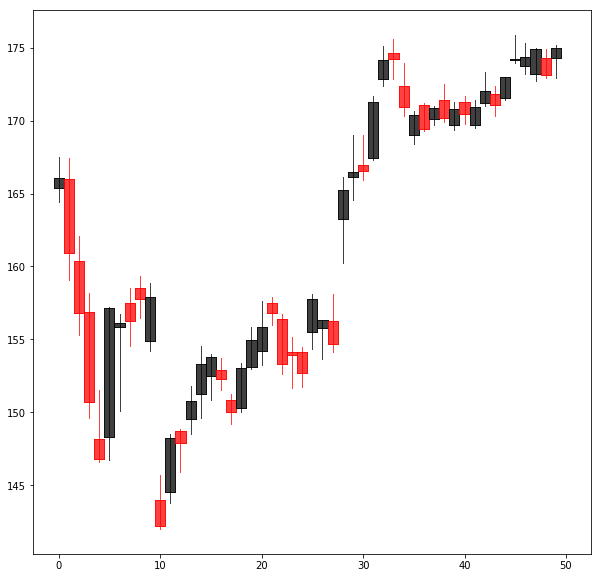

In [31]:
plt.rcParams['figure.figsize'] = (10,10) # Setting default params for figures
fig, ax = plt.subplots()
for items in tech:
    finance.candlestick2_ochl(ax=ax, 
                              opens=items.iloc[-50:, np.argmax(items.columns=='open')], 
                              closes=items.iloc[-50:, np.argmax(items.columns=='close')], 
                              highs=items.iloc[-50:, np.argmax(items.columns=='high')], 
                              lows=items.iloc[-50:, np.argmax(items.columns=='low')],
                              width=1)
    plt.show()